
# Gaussian Mixture Models (GMM): Math, Implementation, and Visualization

This notebook is a complete, self-contained tutorial on **Gaussian Mixture Models (GMM)**.  
It covers:
- Concept & Probabilistic Formulation
- EM Algorithm derivation for GMM
- From-scratch implementation (NumPy)
- Visualization in 1D and 2D
- Model selection with AIC/BIC
- Comparison with `scikit-learn`'s `GaussianMixture`

> **Reproducibility:** I set random seeds where relevant.


In [1]:

# Core imports
import numpy as np
import matplotlib.pyplot as plt

# For comparison & KMeans init
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score

np.random.seed(42)



## 1. Probabilistic Model

A Gaussian Mixture Model assumes data $\{\mathbf{x}_n\}_{n=1}^N$ is generated by a latent mixture component $z_n \in \{1,\dots,K\}$ with categorical prior $\pi_k$ and component-conditional density $\mathcal{N}(\mathbf{x}\mid \boldsymbol{\mu}_k,\boldsymbol{\Sigma}_k)$:

$$
p(\mathbf{x}_n) = \sum_{k=1}^K \pi_k \, \mathcal{N}(\mathbf{x}_n \mid \boldsymbol{\mu}_k,\boldsymbol{\Sigma}_k), \qquad
\sum_{k=1}^K \pi_k = 1,\; \pi_k \ge 0.
$$

The multivariate Gaussian:
$$
\mathcal{N}(\mathbf{x}\mid \boldsymbol{\mu},\boldsymbol{\Sigma}) = \frac{1}{(2\pi)^{D/2}\,|\boldsymbol{\Sigma}|^{1/2}} \exp\!\Big(-\tfrac{1}{2}(\mathbf{x}-\boldsymbol{\mu})^\top \boldsymbol{\Sigma}^{-1}(\mathbf{x}-\boldsymbol{\mu})\Big).
$$

Latent responsibilities (posterior of $z_n$):
$$
\gamma_{nk} \equiv p(z_n=k \mid \mathbf{x}_n) = \frac{\pi_k\,\mathcal{N}(\mathbf{x}_n\mid \boldsymbol{\mu}_k,\boldsymbol{\Sigma}_k)}{\sum_{j=1}^K \pi_j\,\mathcal{N}(\mathbf{x}_n\mid \boldsymbol{\mu}_j,\boldsymbol{\Sigma}_j)}.
$$



## 2. Expectation-Maximization (EM) for GMM

We maximize the observed-data log-likelihood
$$
\mathcal{L}(\Theta) = \sum_{n=1}^N \log\Big(\sum_{k=1}^K \pi_k \,\mathcal{N}(\mathbf{x}_n\mid \boldsymbol{\mu}_k,\boldsymbol{\Sigma}_k)\Big)
$$
with $\Theta=\{\pi_k,\boldsymbol{\mu}_k,\boldsymbol{\Sigma}_k\}_{k=1}^K$.  
EM alternates **E-step** and **M-step** until convergence.

**E-Step:** compute responsibilities
$$
\gamma_{nk} \leftarrow \frac{\pi_k\,\mathcal{N}(\mathbf{x}_n\mid \boldsymbol{\mu}_k,\boldsymbol{\Sigma}_k)}{\sum_{j=1}^K \pi_j\,\mathcal{N}(\mathbf{x}_n\mid \boldsymbol{\mu}_j,\boldsymbol{\Sigma}_j)}.
$$

Define effective counts
$$
N_k = \sum_{n=1}^N \gamma_{nk}.
$$

**M-Step:** update parameters
$$
\pi_k \leftarrow \frac{N_k}{N}, \qquad
\boldsymbol{\mu}_k \leftarrow \frac{1}{N_k}\sum_{n=1}^N \gamma_{nk}\,\mathbf{x}_n,
$$
$$
\boldsymbol{\Sigma}_k \leftarrow \frac{1}{N_k}\sum_{n=1}^N \gamma_{nk}\,(\mathbf{x}_n-\boldsymbol{\mu}_k)(\mathbf{x}_n-\boldsymbol{\mu}_k)^\top.
$$

**Convergence:** stop when the log-likelihood increment is below a tolerance or max iterations reached.



### 2.1 Pseudocode

1. Choose $K$ and initialize $\{\pi_k,\boldsymbol{\mu}_k,\boldsymbol{\Sigma}_k\}$ (e.g., KMeans for $\boldsymbol{\mu}_k$).
2. **Repeat until convergence:**
   - **E-step:** compute responsibilities $\gamma_{nk}$ for all $n,k$.
   - **M-step:** update $\pi_k,\boldsymbol{\mu}_k,\boldsymbol{\Sigma}_k$ using the formulas above.
   - Evaluate log-likelihood; check convergence.


In [2]:

def log_multivariate_normal(x, mean, cov):
    """Compute log N(x | mean, cov) for one sample x (D,), mean (D,), cov (D,D)."""
    D = mean.shape[0]
    xc = x - mean
    try:
        L = np.linalg.cholesky(cov)
    except np.linalg.LinAlgError:
        # Add small jitter for numerical stability
        jitter = 1e-6 * np.eye(D)
        L = np.linalg.cholesky(cov + jitter)
        cov = cov + jitter
    logdet = 2.0 * np.sum(np.log(np.diag(L)))
    sol = np.linalg.solve(L, xc)
    return -0.5 * (D*np.log(2*np.pi) + logdet + sol.T @ sol)


In [3]:

class GMMFromScratch:
    """Gaussian Mixture Model (full covariance) via EM, from scratch (NumPy).

    Parameters
    ----------
    n_components : int
        Number of mixture components K.
    max_iter : int
        Max EM iterations.
    tol : float
        Convergence tolerance on log-likelihood improvement.
    reg_covar : float
        Non-negative regularization added to diagonal of covariance.
    init : str
        'kmeans' or 'random' initialization for means.
    random_state : int or None
        Random seed.
    """
    def __init__(self, n_components=3, max_iter=200, tol=1e-4, reg_covar=1e-6, init='kmeans', random_state=42):
        self.K = n_components
        self.max_iter = max_iter
        self.tol = tol
        self.reg_covar = reg_covar
        self.init = init
        self.random_state = random_state
        self.weights_ = None
        self.means_ = None
        self.covariances_ = None
        self.log_likelihoods_ = []
        self.resp_ = None

    def _initialize_parameters(self, X):
        N, D = X.shape
        rng = np.random.default_rng(self.random_state)

        # Initialize means
        if self.init == 'kmeans':
            km = KMeans(n_clusters=self.K, n_init=10, random_state=self.random_state).fit(X)
            means = km.cluster_centers_
        else:
            idx = rng.choice(N, size=self.K, replace=False)
            means = X[idx]

        # Initialize covariances
        cov = np.cov(X.T)
        covariances = np.array([cov + self.reg_covar*np.eye(D) for _ in range(self.K)])

        # Initialize weights
        weights = np.ones(self.K) / self.K

        self.means_ = means
        self.covariances_ = covariances
        self.weights_ = weights

    def _e_step(self, X):
        N, D = X.shape
        log_resp = np.zeros((N, self.K))
        for k in range(self.K):
            for n in range(N):
                log_resp[n, k] = np.log(self.weights_[k] + 1e-12) + log_multivariate_normal(X[n], self.means_[k], self.covariances_[k])
        # Normalize in log-space
        max_log = np.max(log_resp, axis=1, keepdims=True)
        log_resp -= max_log
        resp = np.exp(log_resp)
        resp /= np.sum(resp, axis=1, keepdims=True)
        self.resp_ = resp
        # Compute log-likelihood
        log_likelihood = np.sum(max_log + np.log(np.sum(np.exp(log_resp), axis=1, keepdims=True)))
        return log_likelihood

    def _m_step(self, X):
        N, D = X.shape
        resp = self.resp_
        Nk = np.sum(resp, axis=0) + 1e-12
        weights = Nk / N
        means = (resp.T @ X) / Nk[:, None]

        covariances = np.zeros((self.K, D, D))
        for k in range(self.K):
            xc = X - means[k]
            cov = (resp[:, k][:, None] * xc).T @ xc / Nk[k]
            cov += self.reg_covar * np.eye(D)
            covariances[k] = cov

        self.weights_ = weights
        self.means_ = means
        self.covariances_ = covariances

    def fit(self, X):
        X = np.asarray(X)
        self._initialize_parameters(X)
        prev_ll = -np.inf
        for it in range(self.max_iter):
            ll = self._e_step(X)
            self._m_step(X)
            self.log_likelihoods_.append(ll)
            if it > 0 and np.abs(ll - prev_ll) < self.tol:
                break
            prev_ll = ll
        return self

    def predict_proba(self, X):
        X = np.asarray(X)
        N = X.shape[0]
        log_resp = np.zeros((N, self.K))
        for k in range(self.K):
            for n in range(N):
                log_resp[n, k] = np.log(self.weights_[k] + 1e-12) + log_multivariate_normal(X[n], self.means_[k], self.covariances_[k])
        # Normalize
        max_log = np.max(log_resp, axis=1, keepdims=True)
        resp = np.exp(log_resp - max_log)
        resp /= np.sum(resp, axis=1, keepdims=True)
        return resp

    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)

    def score(self, X):
        """Average log-likelihood per sample."""
        X = np.asarray(X)
        N = X.shape[0]
        # Compute total log-likelihood
        log_probs = []
        for n in range(N):
            s = 0.0
            for k in range(self.K):
                s += self.weights_[k] * np.exp(log_multivariate_normal(X[n], self.means_[k], self.covariances_[k]))
            log_probs.append(np.log(s + 1e-12))
        return np.mean(log_probs)

    def bic(self, X):
        """Bayesian Information Criterion for model selection."""
        X = np.asarray(X)
        N, D = X.shape
        # Number of parameters: weights (K-1) + means (K*D) + covariances (K * D*(D+1)/2)
        n_params = (self.K - 1) + self.K * D + self.K * (D * (D + 1) // 2)
        ll = self.score(X) * N
        return n_params * np.log(N) - 2 * ll

    def aic(self, X):
        X = np.asarray(X)
        N, D = X.shape
        n_params = (self.K - 1) + self.K * D + self.K * (D * (D + 1) // 2)
        ll = self.score(X) * N
        return 2 * n_params - 2 * ll



## 3. 2D Synthetic Data, EM Fit, and Visualization


Weights: [0.333 0.333 0.333]
Means:
 [[ 4.792  2.072]
 [-6.862 -6.802]
 [-2.516  9.002]]
BIC: 7372.716841678584
AIC: 7291.076130702071


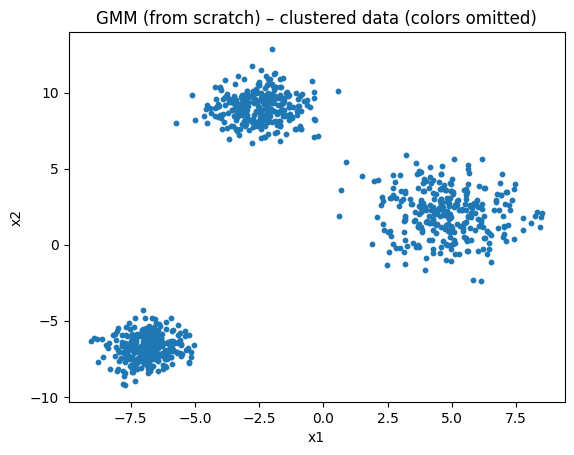

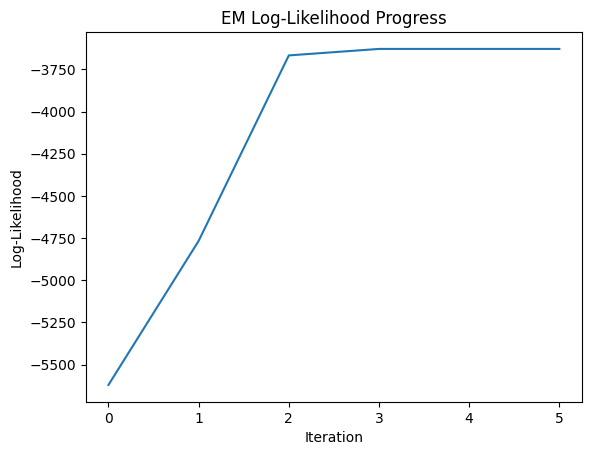

In [4]:

# Generate synthetic 2D blobs
X, y_true = make_blobs(n_samples=900, centers=3, cluster_std=[1.0, 1.5, 0.8], random_state=42, n_features=2)

# Fit our GMM
gmm = GMMFromScratch(n_components=3, max_iter=300, tol=1e-5, reg_covar=1e-6, init='kmeans', random_state=42)
gmm.fit(X)
labels = gmm.predict(X)

print("Weights:", np.round(gmm.weights_, 3))
print("Means:\n", np.round(gmm.means_, 3))
print("BIC:", gmm.bic(X))
print("AIC:", gmm.aic(X))

# Plot clustering result (2D scatter)
plt.figure()
plt.scatter(X[:,0], X[:,1], s=10)
plt.title("GMM (from scratch) – clustered data (colors omitted)")
plt.xlabel("x1"); plt.ylabel("x2")
plt.show()

# Plot log-likelihood curve
plt.figure()
plt.plot(gmm.log_likelihoods_)
plt.title("EM Log-Likelihood Progress")
plt.xlabel("Iteration"); plt.ylabel("Log-Likelihood")
plt.show()


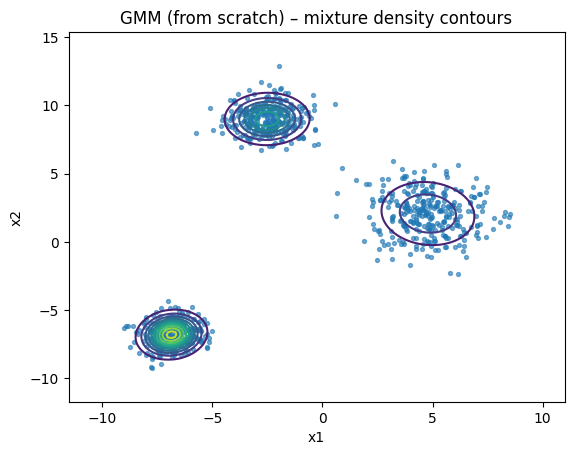

In [5]:

# Visualize mixture density contours over a grid
def mixture_pdf_grid(gmm, X, grid_size=150, padding=2.5):
    x_min, x_max = X[:,0].min()-padding, X[:,0].max()+padding
    y_min, y_max = X[:,1].min()-padding, X[:,1].max()+padding
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, grid_size),
                         np.linspace(y_min, y_max, grid_size))
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = np.zeros(grid.shape[0])
    for i, pt in enumerate(grid):
        s = 0.0
        for k in range(gmm.K):
            s += gmm.weights_[k]*np.exp(log_multivariate_normal(pt, gmm.means_[k], gmm.covariances_[k]))
        Z[i] = s
    return xx, yy, Z.reshape(xx.shape)

xx, yy, Z = mixture_pdf_grid(gmm, X)

plt.figure()
plt.contour(xx, yy, Z, levels=10)
plt.scatter(X[:,0], X[:,1], s=8, alpha=0.6)
plt.title("GMM (from scratch) – mixture density contours")
plt.xlabel("x1"); plt.ylabel("x2")
plt.show()


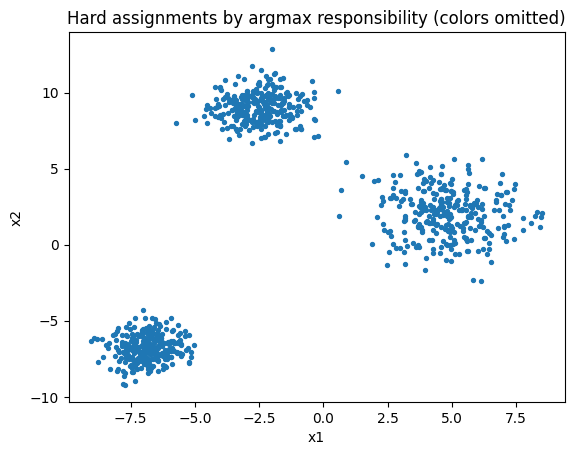

Average max responsibility (confidence): 1.0


In [6]:

# Plot most responsible component regions by argmax(gamma)
resp = gmm.predict_proba(X)
hard = np.argmax(resp, axis=1)

plt.figure()
plt.scatter(X[:,0], X[:,1], s=8)
plt.title("Hard assignments by argmax responsibility (colors omitted)")
plt.xlabel("x1"); plt.ylabel("x2")
plt.show()

# Show average max responsibility (confidence)
avg_conf = np.mean(np.max(resp, axis=1))
print("Average max responsibility (confidence):", round(avg_conf, 4))



## 4. 1D Example (PDF shape and responsibilities)

GMMs are often used for density estimation.  
Below we sample a 1D mixture and fit $K=2$.


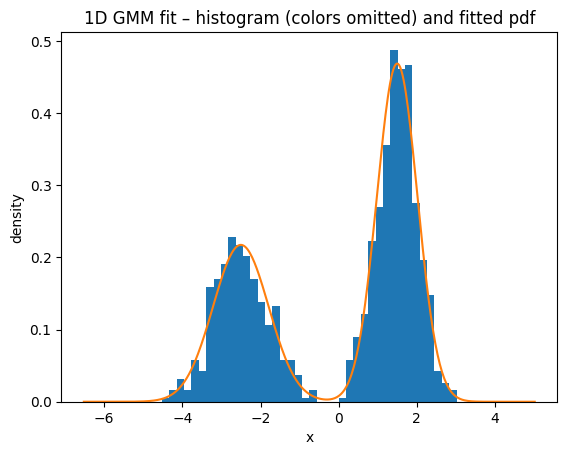

1D Weights: [0.612 0.388]
1D Means: [ 1.497 -2.504]
1D Variances: [np.float64(0.271), np.float64(0.507)]


In [7]:

# 1D synthetic mixture
rng = np.random.default_rng(123)
N = 1000
mix = rng.choice([0,1], size=N, p=[0.4, 0.6])
x = np.zeros(N)
x[mix==0] = rng.normal(loc=-2.5, scale=0.7, size=np.sum(mix==0))
x[mix==1] = rng.normal(loc=1.5, scale=0.5, size=np.sum(mix==1))
X1 = x.reshape(-1,1)

gmm1d = GMMFromScratch(n_components=2, max_iter=300, tol=1e-6, random_state=0)
gmm1d.fit(X1)

# Plot histogram and fitted pdf
xs = np.linspace(x.min()-2, x.max()+2, 400).reshape(-1,1)
pdf_vals = []
for xi in xs:
    s = 0.0
    for k in range(gmm1d.K):
        s += gmm1d.weights_[k]*np.exp(log_multivariate_normal(xi, gmm1d.means_[k], gmm1d.covariances_[k]))
    pdf_vals.append(s)
pdf_vals = np.array(pdf_vals)

plt.figure()
# histogram (density)
plt.hist(x, bins=40, density=True)
plt.plot(xs, pdf_vals)
plt.title("1D GMM fit – histogram (colors omitted) and fitted pdf")
plt.xlabel("x"); plt.ylabel("density")
plt.show()

print("1D Weights:", np.round(gmm1d.weights_, 3))
print("1D Means:", np.round(gmm1d.means_.ravel(), 3))
print("1D Variances:", [np.round(np.diag(cov)[0], 3) for cov in gmm1d.covariances_])



## 5. Choosing **K** with BIC/AIC

We sweep $K$ and compute BIC/AIC on the same dataset.
Lower is better.


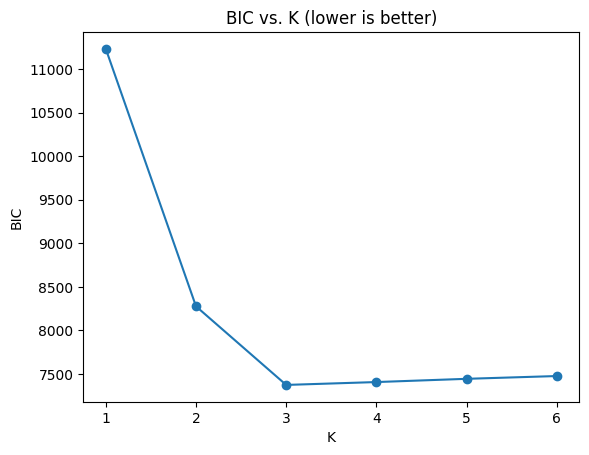

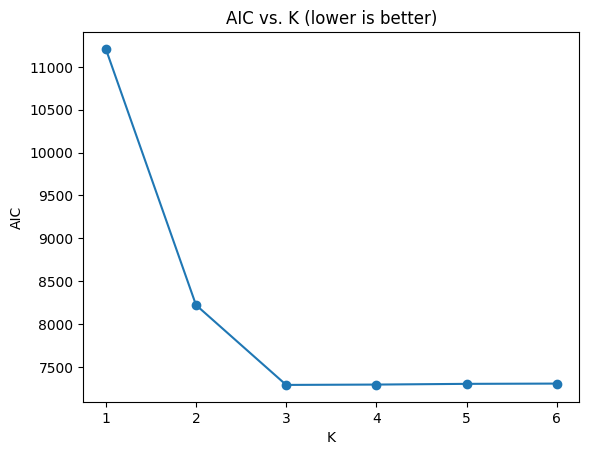

K, BIC, AIC table:
 [[1.00000000e+00 1.12330107e+04 1.12089987e+04]
 [2.00000000e+00 8.27560521e+03 8.22277887e+03]
 [3.00000000e+00 7.37271684e+03 7.29107613e+03]
 [4.00000000e+00 7.40564153e+03 7.29518646e+03]
 [5.00000000e+00 7.44280782e+03 7.30353837e+03]
 [6.00000000e+00 7.47472739e+03 7.30664358e+03]]


In [8]:

def sweep_k_bic_aic(X, K_list, random_state=42):
    results = []
    for K in K_list:
        model = GMMFromScratch(n_components=K, random_state=random_state)
        model.fit(X)
        bic = model.bic(X)
        aic = model.aic(X)
        results.append((K, bic, aic))
    return np.array(results)

K_list = [1,2,3,4,5,6]
res = sweep_k_bic_aic(X, K_list)

plt.figure()
plt.plot(res[:,0], res[:,1], marker='o')
plt.title("BIC vs. K (lower is better)")
plt.xlabel("K"); plt.ylabel("BIC")
plt.show()

plt.figure()
plt.plot(res[:,0], res[:,2], marker='o')
plt.title("AIC vs. K (lower is better)")
plt.xlabel("K"); plt.ylabel("AIC")
plt.show()

print("K, BIC, AIC table:\n", res)



## 6. Comparison with `scikit-learn`'s `GaussianMixture`

We fit the same data using `GaussianMixture` for sanity-check.


sklearn weights: [0.333 0.333 0.333]
sklearn means:
 [[ 4.792  2.072]
 [-6.862 -6.802]
 [-2.516  9.002]]


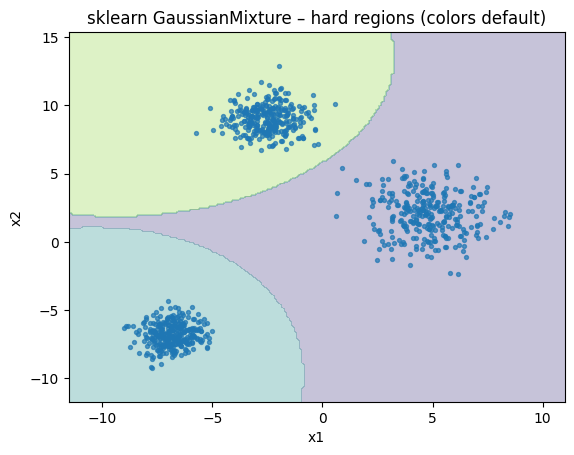

In [9]:

sk_gmm = GaussianMixture(n_components=3, covariance_type='full', random_state=42, n_init=5)
sk_gmm.fit(X)
print("sklearn weights:", np.round(sk_gmm.weights_, 3))
print("sklearn means:\n", np.round(sk_gmm.means_, 3))

# Plot decision regions via argmax responsibilities (on a grid)
def plot_gmm_regions(gmm_sklearn, X, grid_size=200, padding=2.5):
    x_min, x_max = X[:,0].min()-padding, X[:,0].max()+padding
    y_min, y_max = X[:,1].min()-padding, X[:,1].max()+padding
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, grid_size),
                         np.linspace(y_min, y_max, grid_size))
    grid = np.c_[xx.ravel(), yy.ravel()]
    resp = gmm_sklearn.predict_proba(grid)
    hard = np.argmax(resp, axis=1).reshape(xx.shape)
    plt.figure()
    plt.contourf(xx, yy, hard, levels=np.arange(gmm_sklearn.n_components+1)-0.5, alpha=0.3)
    plt.scatter(X[:,0], X[:,1], s=8, alpha=0.7)
    plt.title("sklearn GaussianMixture – hard regions (colors default)")
    plt.xlabel("x1"); plt.ylabel("x2")
    plt.show()

plot_gmm_regions(sk_gmm, X)



## 7. Practical Notes

- Initialization matters; KMeans is a good default for $\boldsymbol{\mu}_k$.
- Use a small diagonal **regularizer** $\mathrm{reg\_covar}$ to keep $\boldsymbol{\Sigma}_k$ positive-definite.
- Monitor **log-likelihood**; it should not decrease over EM iterations.
- Try **diagonal covariances** when $D$ is large (not implemented here, but straightforward).
- Use **BIC/AIC** and **silhouette** (for clustering perspective) to help pick $K$.
- For **high-dimensional** data, consider PCA before fitting a GMM.


In [10]:

# Optional: Silhouette as a clustering diagnostic (not a density metric)
labels_from_sklearn = sk_gmm.predict(X)
sil = silhouette_score(X, labels_from_sklearn)
print("Silhouette score (sklearn labels):", round(sil, 4))


Silhouette score (sklearn labels): 0.8214
